In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pandas_profiling import ProfileReport
from datetime import datetime

,Sensor_id,Device_id,Latitude,Longitude,Speed,Date,Time,Channel1,Channel2,max_overload
Sensor_id,1.000000,NaN,-0.034664,-0.001956,0.030834,-0.052857,-0.040333,-0.183173,-0.166597,-0.223741
Device_id,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Latitude,-0.034664,NaN,1.000000,0.785108,-0.493021,0.551999,0.212938,-0.030076,-0.022364,-0.023399
Longitude,-0.001956,NaN,0.785108,1.000000,-0.504127,0.274244,0.093080,-0.047373,-0.025660,-0.029486
Speed,0.030834,NaN,-0.493021,-0.504127,1.000000,-0.306201,-0.014414,0.012908,0.040229,0.019886
Date,-0.052857,NaN,0.551999,0.274244,-0.306201,1.000000,0.298695,-0.003604,0.055916,0.040599
Time,-0.040333,NaN,0.212938,0.093080,-0.014414,0.298695,1.000000,0.028104,-0.007802,0.030446
Channel1,-0.183173,NaN,-0.030076,-0.047373,0.012908,-0.003604,0.028104,1.000000,0.024071,0.736152
Channel2,-0.166597,NaN,-0.022364,-0.025660,0.040229,0.055916,-0.007802,0.024071,1.000000,0.670751
max_overload,-0.223741,NaN,-0.023399,-0.029486,0.019886,0.040599,0.030446,0.736152,0.670751,1.000000


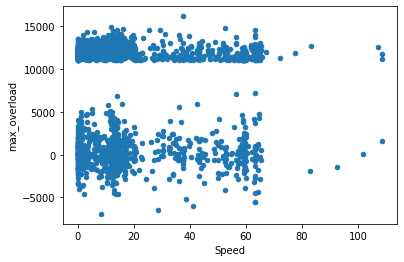

In [65]:
df1 = pd.read_csv('357164042518400_OLs.csv', delimiter=';', names=["Sensor_id", "Channel", "Device_id", "Latitude",
                                                                   "Longitude", "Speed", "Date", "Time", "Channel1", "Channel2"])
df1
dddddd = df1.copy()
dddddd['max_overload'] = np.max(
    dddddd[['Channel1', 'Channel2']].values, axis=1)
dddddd.where(0 < dddddd['Speed']).plot.scatter(
    'Speed', 'max_overload')
dddddd.where(0 < dddddd['Speed']).corr()


The acquired value is an integer number `[digit]` between 32768 and -32768. It can be converted
into a stress load using the sensitivity of 0.0068 `[MPa/digit]`. The absolute value is much more
important than the integer.

In [3]:
df1[['Channel1', 'Channel2']] = df1[['Channel1', 'Channel2']].apply(lambda x: abs(x * 0.0068), axis=1)
df1

,Sensor_id,Channel,Device_id,Latitude,Longitude,Speed,Date,Time,Channel1,Channel2
0,60040,CANALE1,357164042518400,59.374611,17.997831,0.0,20210304,41113,76.1600,32.2048
1,60040,CANALE1,357164042518400,59.374611,17.997852,0.0,20210304,41113,76.6020,3.4748
2,60040,CANALE1,357164042518400,59.374611,17.997877,0.0,20210304,41114,84.7552,15.6604
3,60040,CANALE1,357164042518400,59.374610,17.997900,0.0,20210304,41114,76.6020,3.4748
4,60040,CANALE1,357164042518400,59.374609,17.997925,0.0,20210304,41114,79.1792,9.9552
...,...,...,...,...,...,...,...,...,...,...
12600,61040,CANALE2,357164042518400,59.376685,17.991453,0.0,20211108,23941,15.6740,76.4796
12601,61040,CANALE2,357164042518400,59.376677,17.991481,0.0,20211108,23941,4.4608,78.0096
12602,61040,CANALE2,357164042518400,59.376670,17.991506,0.0,20211108,23941,3.8080,76.6496
12603,61040,CANALE2,357164042518400,59.376638,17.991621,0.0,20211108,23943,5.6576,75.7248


In [4]:
df1['Time'] = df1['Time'].apply(lambda x: str(
    datetime.strptime(str(x), "%H%M%S").time()))
df1['Date'] = df1['Date'].apply(lambda x: str(
    datetime.strptime(str(x), "%Y%m%d").date()))
df1


,Sensor_id,Channel,Device_id,Latitude,Longitude,Speed,Date,Time,Channel1,Channel2
0,60040,CANALE1,357164042518400,59.374611,17.997831,0.0,2021-03-04,04:11:13,76.1600,32.2048
1,60040,CANALE1,357164042518400,59.374611,17.997852,0.0,2021-03-04,04:11:13,76.6020,3.4748
2,60040,CANALE1,357164042518400,59.374611,17.997877,0.0,2021-03-04,04:11:14,84.7552,15.6604
3,60040,CANALE1,357164042518400,59.374610,17.997900,0.0,2021-03-04,04:11:14,76.6020,3.4748
4,60040,CANALE1,357164042518400,59.374609,17.997925,0.0,2021-03-04,04:11:14,79.1792,9.9552
...,...,...,...,...,...,...,...,...,...,...
12600,61040,CANALE2,357164042518400,59.376685,17.991453,0.0,2021-11-08,23:09:41,15.6740,76.4796
12601,61040,CANALE2,357164042518400,59.376677,17.991481,0.0,2021-11-08,23:09:41,4.4608,78.0096
12602,61040,CANALE2,357164042518400,59.376670,17.991506,0.0,2021-11-08,23:09:41,3.8080,76.6496
12603,61040,CANALE2,357164042518400,59.376638,17.991621,0.0,2021-11-08,23:09:43,5.6576,75.7248


In [5]:
df1['max_overload'] = np.max(df1[['Channel1', 'Channel2']].values, axis=1)

In [6]:
overloads = np.max(df1[['Channel1', 'Channel2']].values, axis=1)
overloads[overloads > 85].shape

(3772,)

## Calculate distances

In [7]:
from math import radians, cos, sin, asin, sqrt
def distance(lat1, lat2, lon1, lon2):
     
    # The math module contains a function named
    # radians which converts from degrees to radians.
    lon1 = radians(lon1)
    lon2 = radians(lon2)
    lat1 = radians(lat1)
    lat2 = radians(lat2)
      
    # Haversine formula
    dlon = lon2 - lon1
    dlat = lat2 - lat1
    a = sin(dlat / 2)**2 + cos(lat1) * cos(lat2) * sin(dlon / 2)**2
 
    c = 2 * asin(sqrt(a))
    
    # Radius of earth in kilometers. Use 3956 for miles
    r = 6371
      
    # calculate the result
    return(c * r)
     
     
# driver code
lat1 = 53.32055555555556
lat2 = 53.31861111111111
lon1 = -1.7297222222222221
lon2 =  -1.6997222222222223
print(distance(lat1, lat2, lon1, lon2), "K.M")

2.0043678382716137 K.M


In [8]:
a = np.sqrt(np.sum((np.array([lat1, lon1]) - np.array([lat2, lon2]))**2))
b = distance(lat1, lat2, lon1, lon2) * 1000

five_meter_degree = (5 * a) / b
print(five_meter_degree)

7.49935909658473e-05


In [9]:
from sklearn.cluster import MeanShift

mean_shift = MeanShift(bandwidth=five_meter_degree)

We cluster the coordinates in each day

In [10]:
# first calculate for one day
coordinates = df1[['Latitude', 'Longitude']].values

In [11]:
mean_shift.fit(coordinates)
mean_shift.labels_

array([ 76,  76,  76, ..., 275, 714, 833])

In [12]:
np.unique(mean_shift.labels_)

array([   0,    1,    2, ..., 1077, 1078, 1079])

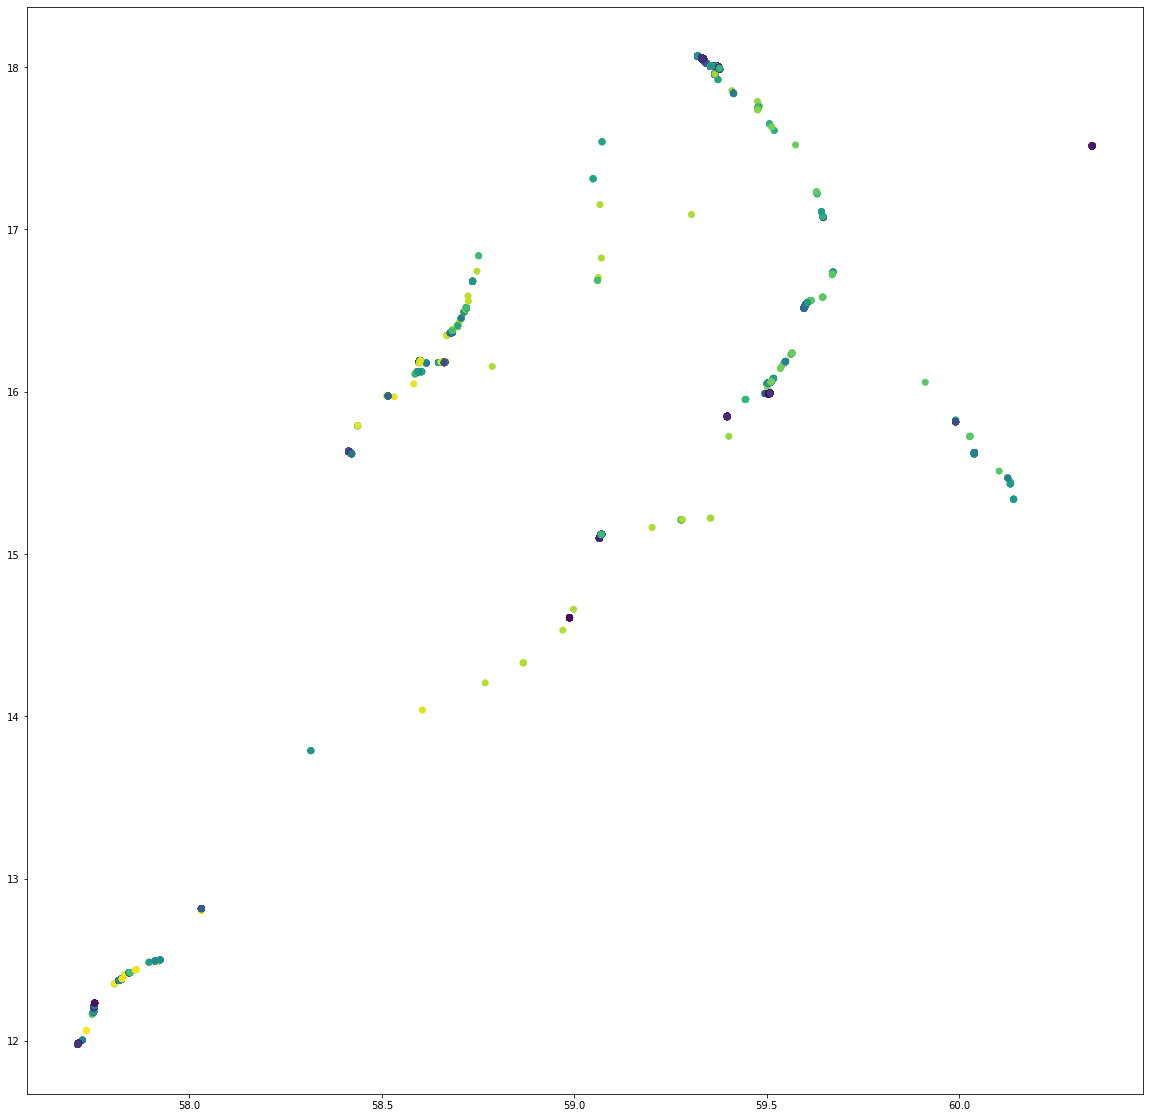

In [13]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.figure(figsize=(20, 20))
# coordinates = df1[['Latitude', 'Longitude']].values
plt.scatter(coordinates[:, 0], coordinates[:, 1], c=mean_shift.labels_)
plt.show()

In [14]:
df1['5m_cluster'] = mean_shift.labels_


In [15]:
df1_clone = df1.copy()
df1_clone_grouped = df1_clone.groupby('5m_cluster').first()
df1_clone_grouped = df1_clone_grouped.sort_values(by='Date')
df1_clone_grouped


,Sensor_id,Channel,Device_id,Latitude,Longitude,Speed,Date,Time,Channel1,Channel2,max_overload
5m_cluster,,,,,,,,,,,
134,60040,CANALE1,357164042518400,59.374251,18.000485,0.0,2021-03-04,04:11:38,77.5744,10.8800,77.5744
172,60040,CANALE1,357164042518400,59.332705,18.053419,0.0,2021-03-04,04:21:30,77.4384,19.7472,77.4384
711,60040,CANALE1,357164042518400,59.443825,15.951563,0.0,2021-03-04,06:04:18,77.9008,28.9408,77.9008
23,60040,CANALE1,357164042518400,59.372817,18.003416,0.0,2021-03-04,04:12:14,87.8016,7.9424,87.8016
49,60040,CANALE1,357164042518400,59.373593,18.002372,0.0,2021-03-04,04:11:58,83.3408,4.3520,83.3408
...,...,...,...,...,...,...,...,...,...,...,...
275,60040,CANALE1,357164042518400,59.376689,17.991436,0.0,2021-11-08,23:09:41,76.5952,4.7872,76.5952
714,61040,CANALE1,357164042518400,59.376636,17.991631,0.0,2021-11-08,23:09:43,75.2012,4.6852,75.2012
222,60040,CANALE1,357164042518400,59.376777,17.990740,0.0,2021-11-08,23:09:33,79.1044,16.7280,79.1044


•
It’s interesting to monitor the variation of the overloads during time; whether the values
increase, decrease or remain constant

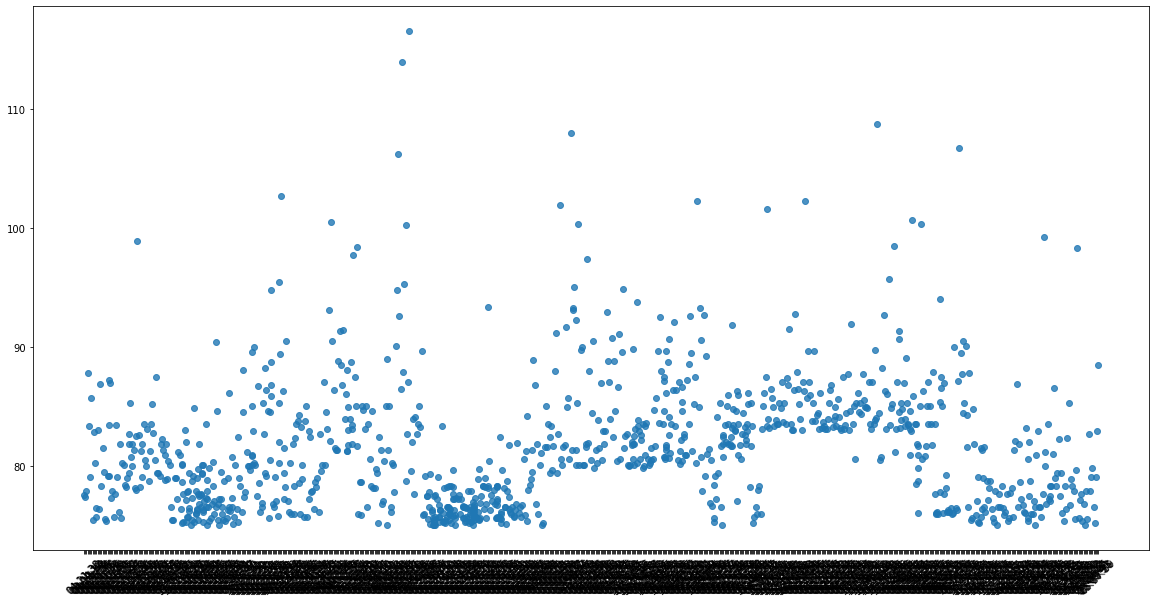

In [16]:
# plot the overloads during date

plt.figure(figsize=(20, 10))

plt.scatter(df1_clone_grouped['Time'].values, df1_clone_grouped[['Channel1', 'Channel2']].values.max(1),alpha=0.8)
plt.xticks(rotation=45)
plt.show()

In [17]:
    
df2 = pd.read_csv('357164042518400_THs.csv', delimiter=';', names=["Sensor_id", "Channel", "Device_id", "Latitude",
                                                                   "Longitude", "Speed", "Date", "Time"], skiprows=lambda x: x % 2 != 0)
df2['Time'] = df2['Time'].apply(lambda x: str(datetime.strptime(str(x), "%H%M%S").time()))
df2['Date'] = df2['Date'].apply(lambda x: str(datetime.strptime(str(x), "%Y%m%d").date()))
df2

,Sensor_id,Channel,Device_id,Latitude,Longitude,Speed,Date,Time
0,60040,CANALE1,357164042518400,59.372755,18.003537,0.0,2021-03-04,04:12:15
1,60040,CANALE1,357164042518400,59.373505,18.002518,0.0,2021-03-04,04:12:00
2,60040,CANALE1,357164042518400,59.373719,18.002101,0.0,2021-03-04,04:11:54
3,60040,CANALE1,357164042518400,59.374128,18.001012,0.0,2021-03-04,04:11:43
4,60040,CANALE1,357164042518400,59.372899,18.003275,0.0,2021-03-04,04:12:12
...,...,...,...,...,...,...,...,...
388,60040,CANALE2,357164042518400,59.505874,15.988249,0.0,2021-10-20,15:51:10
389,60040,CANALE2,357164042518400,59.507716,15.990146,0.0,2021-10-20,15:51:20
390,60040,CANALE2,357164042518400,59.506697,15.988626,0.0,2021-10-20,15:51:14
391,60040,CANALE2,357164042518400,59.334602,18.050718,0.0,2021-10-21,05:19:07


In [18]:
df3 = pd.read_csv('357164042518400_THs.csv', delimiter=';',
                  skiprows=lambda x: x % 2 == 0, names=list(range(5001)))
df4 = df3.abs().max(axis=1)
df2['time_series_overload'] = df4


In [19]:
df2[['time_series_overload']] = df2[['time_series_overload']].apply(
    lambda x: abs(x * 0.0068), axis=1)



In [20]:
date_time_1 = df1[['Date', 'Time']].values.tolist()
date_time_2 = df2[['Date','Time']].values.tolist()

dt_1 = list(map(' '.join, date_time_1))
dt_2 = list(map(' '.join, date_time_2))
counter = 0
for date, overload1, coor1 in zip(dt_1, np.max(df1[['Channel1', 'Channel2']].values, axis=1).tolist(), df1[['Latitude', 'Longitude']].values.tolist()):
    for d, overload2, coor2 in zip(dt_2, df2['time_series_overload'].values.tolist(), df2[['Latitude', 'Longitude']].values.tolist()):
        if date == d and overload1==overload2 and coor1 == coor2:
            counter += 1
print(counter)

counter = 0
for date, overload1 in zip(dt_1, df1[['Latitude', 'Longitude']].values.tolist()):
    for d, overload2 in zip(dt_2, df2[['Latitude', 'Longitude']].values.tolist()):
        if date == d and overload1==overload2:
            counter += 1
print(counter)

390
481


In [21]:
mean_shift_2 = MeanShift(bandwidth=five_meter_degree)

mean_shift_2.fit(df2[['Latitude', 'Longitude']].values)
df2_clusters = mean_shift_2.labels_
print(df2_clusters)

[  7  42  39   2   6  50  54  59  95  97 256  96  98 254 252 251 152  45
 177 161 155 184  49 109 108 162   5  41  38   7   6  53  51  60 209   8
  62  47  44  40   2 181  65  72  68  27 121 120  21 103 105 102 106  20
  24  22  23  88  83 111 257 100 260 101  99 140 219 139 142 143 146  79
 195  58 187  48 157  12  35 159 160 166 145 135 193 194 217  74 210 179
 175   4   3 171 168 188  14  76 200 110 262  34 150 165  13   4   5  37
  15  71 249  82 230  81 228  11   0 127 131  10 118  64  19  70 214   9
   9  84  86  87  17  17  18  90 235 234  75 231  85 236  94  92  93 201
 205 223  89 240 239  91 246 183  55 149   1   1 123 122 191   8  77 212
  73  36 172  52  46  43   3  16  69  63  61  31 125  29  30  10  26 119
  56  57  66 197  80  25 224 226  12 222 144 137  33  78 147  11 130 113
  67 208 151 153   6  42  39   2   7  50  54  59 216  95 247 133  96  97
  98 255 253 250  45 174 173 164 163 185  49 115   6  38  41 170   5   7
  53  51  60  16   8  62  47 182  44  40   2  15  7

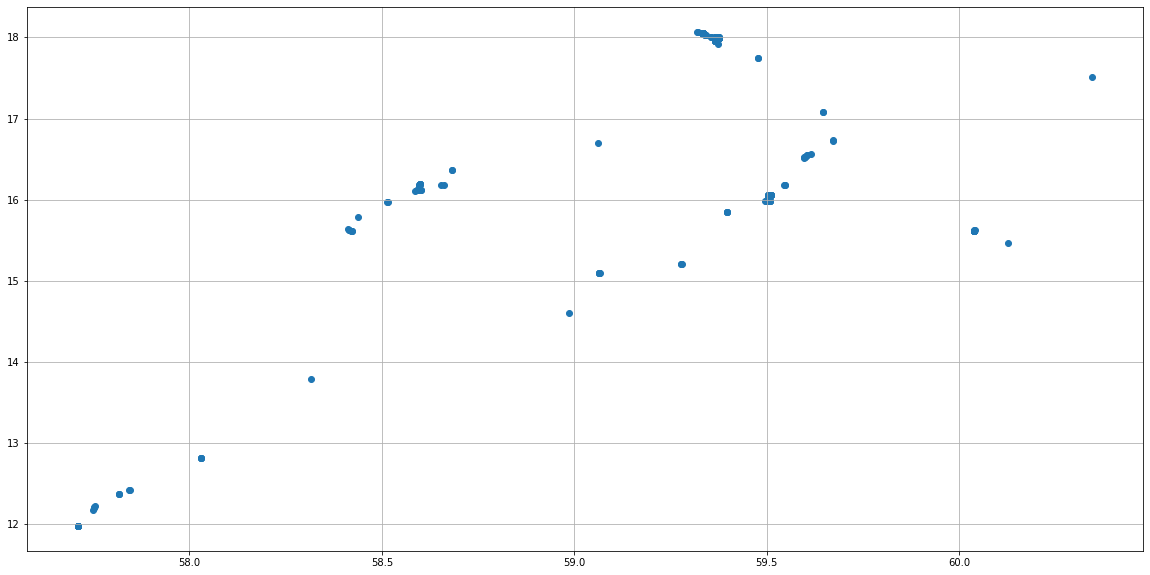

In [22]:
df2_centers = mean_shift_2.cluster_centers_
plt.figure(figsize=(20, 10))
plt.scatter(df2_centers[:, 0], df2_centers[:, 1])
plt.grid()
plt.show()

To show just the points that are important (e.g. important nod in each five meters)

In [23]:
important_nodes = []
for cluster in np.unique(df1['5m_cluster'].values):
    important_nodes.append(df1.loc[df1['5m_cluster']==cluster].sort_values('max_overload', ascending=False).iloc[0].values.tolist())
  


In [24]:
important_nodes_df = pd.DataFrame(important_nodes, columns=df1.columns)
imp_coord = important_nodes_df[['Latitude', 'Longitude']].values
important_nodes_df

,Sensor_id,Channel,Device_id,Latitude,Longitude,Speed,Date,Time,Channel1,Channel2,max_overload,5m_cluster
0,60040,CANALE2,357164042518400,59.507846,15.990516,0.000000,2021-07-06,09:26:46,5.6576,84.8640,84.8640,0
1,61040,CANALE1,357164042518400,59.504811,15.988259,0.000000,2021-08-20,05:46:53,93.0784,0.0000,93.0784,1
2,61040,CANALE1,357164042518400,59.597706,16.521523,0.069127,2021-09-07,08:58:10,85.7344,10.4176,85.7344,2
3,60040,CANALE2,357164042518400,59.507988,15.990847,0.000000,2021-08-25,05:29:43,5.1136,86.2784,86.2784,3
4,60040,CANALE2,357164042518400,59.505526,15.988311,0.000000,2021-07-06,09:26:33,4.6784,91.8816,91.8816,4
...,...,...,...,...,...,...,...,...,...,...,...,...
1075,60040,CANALE1,357164042518400,57.748472,12.167601,0.000000,2021-03-06,05:07:57,82.2528,5.4400,82.2528,1075
1076,60040,CANALE1,357164042518400,57.747806,12.165386,26.529122,2021-04-03,06:08:27,76.5884,4.8960,76.5884,1076
1077,60040,CANALE1,357164042518400,57.732783,12.064450,0.000000,2021-06-12,04:04:47,82.6880,2.2848,82.6880,1077
1078,61040,CANALE1,357164042518400,57.732748,12.063970,0.000000,2021-09-26,04:55:14,82.1440,26.3296,82.1440,1078


<AxesSubplot:>

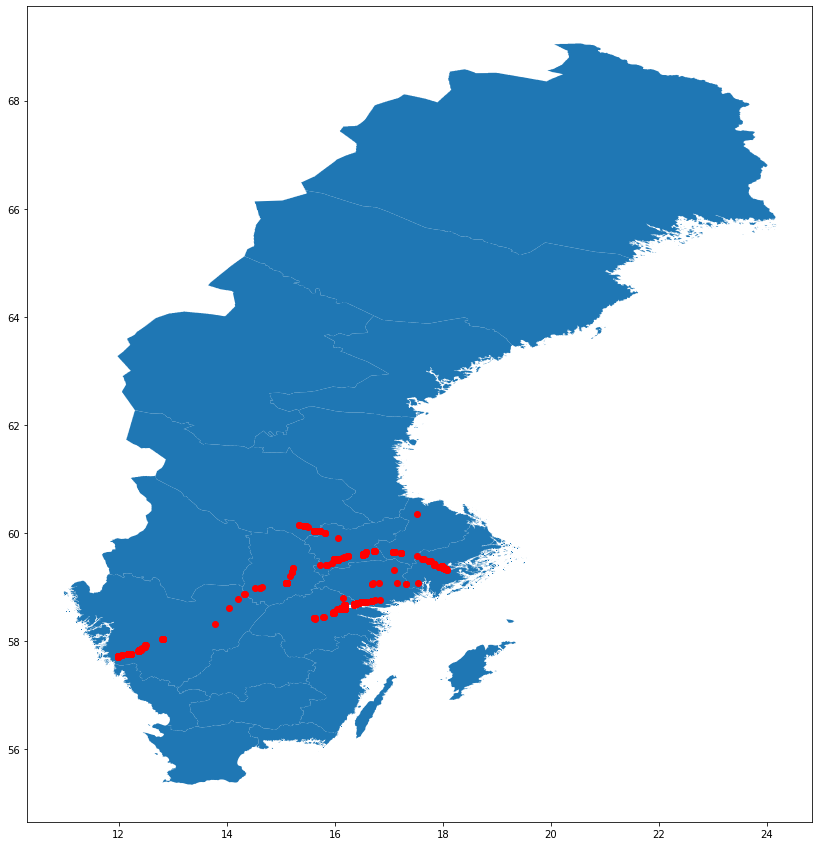

In [25]:
import geopandas as gpd
gdf = gpd.GeoDataFrame(important_nodes_df, geometry=gpd.points_from_xy(
    important_nodes_df.Longitude, important_nodes_df.Latitude))


sweden_map = gpd.read_file('gis_map/test.shp')
ax = sweden_map.plot(figsize=(15, 15))
gdf.plot(ax=ax, color='red')

### the variation of the overloads according to speed

,Sensor_id,Device_id,Latitude,Longitude,Speed,Channel1,Channel2,max_overload,5m_cluster,velocity
Sensor_id,1.000000,NaN,0.061417,-0.019832,-0.028443,0.195462,-0.211002,0.031581,0.017373,-0.022608
Device_id,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Latitude,0.061417,NaN,1.000000,0.816730,-0.332558,0.005218,0.089722,0.420575,-0.372687,0.105101
Longitude,-0.019832,NaN,0.816730,1.000000,-0.354333,-0.103438,0.154868,0.332865,-0.300730,0.018988
Speed,-0.028443,NaN,-0.332558,-0.354333,1.000000,-0.072592,0.014206,-0.335865,0.440275,0.006643
Channel1,0.195462,NaN,0.005218,-0.103438,-0.072592,1.000000,-0.961119,0.217794,-0.122085,0.049364
Channel2,-0.211002,NaN,0.089722,0.154868,0.014206,-0.961119,1.000000,0.000927,-0.002127,-0.005153
max_overload,0.031581,NaN,0.420575,0.332865,-0.335865,0.217794,0.000927,1.000000,-0.637978,0.121009
5m_cluster,0.017373,NaN,-0.372687,-0.300730,0.440275,-0.122085,-0.002127,-0.637978,1.000000,-0.080343
velocity,-0.022608,NaN,0.105101,0.018988,0.006643,0.049364,-0.005153,0.121009,-0.080343,1.000000


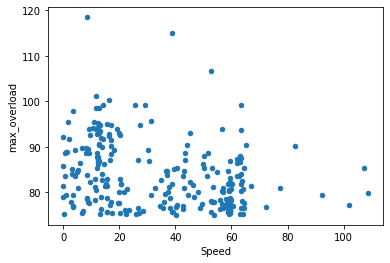

In [63]:
important_nodes_df.where(0 < important_nodes_df['Speed']).plot.scatter('Speed', 'max_overload')
important_nodes_df.where(0 < important_nodes_df['Speed']).corr()

### the trend of the velocity

In [27]:
# x1 = df1
df1_imp_copy = important_nodes_df.copy()
datetime = list(map(' '.join, df1_imp_copy[['Date', 'Time']].values.tolist()))
df1_imp_copy['Datetime'] = pd.to_datetime(pd.Series(datetime))
df1_imp_copy

,Sensor_id,Channel,Device_id,Latitude,Longitude,Speed,Date,Time,Channel1,Channel2,max_overload,5m_cluster,geometry,Datetime
0,60040,CANALE2,357164042518400,59.507846,15.990516,0.000000,2021-07-06,09:26:46,5.6576,84.8640,84.8640,0,POINT (15.99052 59.50785),2021-07-06 09:26:46
1,61040,CANALE1,357164042518400,59.504811,15.988259,0.000000,2021-08-20,05:46:53,93.0784,0.0000,93.0784,1,POINT (15.98826 59.50481),2021-08-20 05:46:53
2,61040,CANALE1,357164042518400,59.597706,16.521523,0.069127,2021-09-07,08:58:10,85.7344,10.4176,85.7344,2,POINT (16.52152 59.59771),2021-09-07 08:58:10
3,60040,CANALE2,357164042518400,59.507988,15.990847,0.000000,2021-08-25,05:29:43,5.1136,86.2784,86.2784,3,POINT (15.99085 59.50799),2021-08-25 05:29:43
4,60040,CANALE2,357164042518400,59.505526,15.988311,0.000000,2021-07-06,09:26:33,4.6784,91.8816,91.8816,4,POINT (15.98831 59.50553),2021-07-06 09:26:33
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1075,60040,CANALE1,357164042518400,57.748472,12.167601,0.000000,2021-03-06,05:07:57,82.2528,5.4400,82.2528,1075,POINT (12.16760 57.74847),2021-03-06 05:07:57
1076,60040,CANALE1,357164042518400,57.747806,12.165386,26.529122,2021-04-03,06:08:27,76.5884,4.8960,76.5884,1076,POINT (12.16539 57.74781),2021-04-03 06:08:27
1077,60040,CANALE1,357164042518400,57.732783,12.064450,0.000000,2021-06-12,04:04:47,82.6880,2.2848,82.6880,1077,POINT (12.06445 57.73278),2021-06-12 04:04:47
1078,61040,CANALE1,357164042518400,57.732748,12.063970,0.000000,2021-09-26,04:55:14,82.1440,26.3296,82.1440,1078,POINT (12.06397 57.73275),2021-09-26 04:55:14


In [28]:
# a = df1_copy['Datetime'].iloc[2] - df1_copy['Datetime'].iloc[1000]
# a.seconds
df1_imp_copy = df1_imp_copy.sort_values('Datetime')

In [29]:
total_velocity = []
for date in np.unique(df1_imp_copy['Date'].values).tolist():  # select the unique values of the dates and convert it to list
    temp_df = df1_imp_copy.loc[df1_imp_copy['Date'] == date]
    coords = temp_df[['Latitude', 'Longitude']].values
    x1 = coords[:-1]
    x2 = coords[1:]
    if not x1.tolist():
        velocity = [0]
        total_velocity += velocity
        continue

    delta_x = np.linalg.norm(x2 - x1, axis=1)
    delta_x_meter = delta_x / (five_meter_degree / 5)

    time1 = temp_df['Datetime'].iloc[:-1].apply(lambda x: x.timestamp()).values # we covert to timestamp this because of zero time conversion.
    time2 = temp_df['Datetime'].iloc[1:].apply(lambda x: x.timestamp()).values  # we covert to timestamp this because of zero time conversion.
    delta_t = (time2 - time1) + 0.1
    velocity = delta_x_meter / delta_t
    velocity *= 3.6
    velocity = [0] + velocity.tolist() # add zero for the end of line
    total_velocity += velocity

df1_imp_copy['velocity'] = total_velocity
df1_imp_copy

    

,Sensor_id,Channel,Device_id,Latitude,Longitude,Speed,Date,Time,Channel1,Channel2,max_overload,5m_cluster,geometry,Datetime,velocity
49,60040,CANALE2,357164042518400,59.373562,18.002432,0.0,2021-03-04,04:11:58,2.8288,92.6976,92.6976,49,POINT (18.00243 59.37356),2021-03-04 04:11:58,0.000000
37,60040,CANALE2,357164042518400,59.373499,18.002525,0.0,2021-03-04,04:12:00,3.4544,95.7168,95.7168,37,POINT (18.00252 59.37350),2021-03-04 04:12:00,12.866356
13,60040,CANALE2,357164042518400,59.373024,18.003133,0.0,2021-03-04,04:12:09,6.0928,94.0032,94.0032,13,POINT (18.00313 59.37302),2021-03-04 04:12:09,20.361497
23,61040,CANALE1,357164042518400,59.372716,18.003608,0.0,2021-03-04,04:12:16,95.4584,5.4944,95.4584,23,POINT (18.00361 59.37272),2021-03-04 04:12:16,19.148898
216,61040,CANALE2,357164042518400,59.372369,18.004204,0.0,2021-03-04,04:12:23,2.3936,83.5040,83.5040,216,POINT (18.00420 59.37237),2021-03-04 04:12:23,23.293588
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
906,60040,CANALE1,357164042518400,59.376789,17.990655,0.0,2021-11-08,23:09:32,79.8592,6.5280,79.8592,906,POINT (17.99066 59.37679),2021-11-08 23:09:32,30.833731
222,60040,CANALE1,357164042518400,59.376770,17.990819,0.0,2021-11-08,23:09:34,90.1952,2.6112,90.1952,222,POINT (17.99082 59.37677),2021-11-08 23:09:34,18.762946
275,61040,CANALE1,357164042518400,59.376674,17.991494,0.0,2021-11-08,23:09:41,80.1856,2.2848,80.1856,275,POINT (17.99149 59.37667),2021-11-08 23:09:41,23.051533
714,61040,CANALE2,357164042518400,59.376638,17.991621,0.0,2021-11-08,23:09:43,5.6576,75.7248,75.7248,714,POINT (17.99162 59.37664),2021-11-08 23:09:43,15.126737


In [30]:
important_nodes_df['velocity'] = total_velocity

In [31]:
# Calculate velocity on complete data
df1_copy = df1.copy()
datetime = list(map(' '.join, df1_copy[['Date', 'Time']].values.tolist()))
df1_copy['Datetime'] = pd.to_datetime(pd.Series(datetime))

df1_copy = df1_copy.sort_values('Datetime')

total_velocity = []
for date in np.unique(df1_copy['Date'].values).tolist():  # select the unique values of the dates and convert it to list
    temp_df = df1_copy.loc[df1_copy['Date'] == date]
    coords = temp_df[['Latitude', 'Longitude']].values
    x1 = coords[:-1]
    x2 = coords[1:]
    if not x1.tolist():
        velocity = [0]
        total_velocity += velocity
        continue

    delta_x = np.linalg.norm(x2 - x1, axis=1)
    delta_x_meter = delta_x / (five_meter_degree / 5)

    time1 = temp_df['Datetime'].iloc[:-1].apply(lambda x: x.timestamp()).values # we covert to timestamp this because of zero time conversion.
    time2 = temp_df['Datetime'].iloc[1:].apply(lambda x: x.timestamp()).values  # we covert to timestamp this because of zero time conversion.
    delta_t = (time2 - time1) + 0.1
    velocity = delta_x_meter / delta_t
    velocity *= 3.6
    velocity = [0] + velocity.tolist() # add zero for the end of line
    total_velocity += velocity

df1['velocity'] = total_velocity
df1


,Sensor_id,Channel,Device_id,Latitude,Longitude,Speed,Date,Time,Channel1,Channel2,max_overload,5m_cluster,velocity
0,60040,CANALE1,357164042518400,59.374611,17.997831,0.0,2021-03-04,04:11:13,76.1600,32.2048,76.1600,76,0.000000
1,60040,CANALE1,357164042518400,59.374611,17.997852,0.0,2021-03-04,04:11:13,76.6020,3.4748,76.6020,76,24.748819
2,60040,CANALE1,357164042518400,59.374611,17.997877,0.0,2021-03-04,04:11:14,84.7552,15.6604,84.7552,76,6.065887
3,60040,CANALE1,357164042518400,59.374610,17.997900,0.0,2021-03-04,04:11:14,76.6020,3.4748,76.6020,76,62.114683
4,60040,CANALE1,357164042518400,59.374609,17.997925,0.0,2021-03-04,04:11:14,79.1792,9.9552,79.1792,76,89.047221
...,...,...,...,...,...,...,...,...,...,...,...,...,...
12600,61040,CANALE2,357164042518400,59.376685,17.991453,0.0,2021-11-08,23:09:41,15.6740,76.4796,76.4796,275,126.967055
12601,61040,CANALE2,357164042518400,59.376677,17.991481,0.0,2021-11-08,23:09:41,4.4608,78.0096,78.0096,275,30.359506
12602,61040,CANALE2,357164042518400,59.376670,17.991506,0.0,2021-11-08,23:09:41,3.8080,76.6496,76.6496,275,23.047543
12603,61040,CANALE2,357164042518400,59.376638,17.991621,0.0,2021-11-08,23:09:43,5.6576,75.7248,75.7248,714,23.384502


### it is assumed that the higher velocity, the higher overload

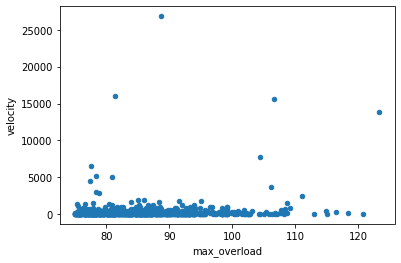

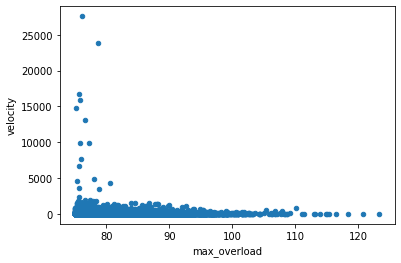

In [32]:
important_nodes_df.plot.scatter('max_overload', 'velocity')
plt.show()

df1.plot.scatter('max_overload', 'velocity')
plt.show()

count    12605.000000
mean       109.492095
std        480.397695
min          0.000000
25%         16.554437
50%         47.078266
75%        109.891466
max      27576.740267
Name: velocity, dtype: float64


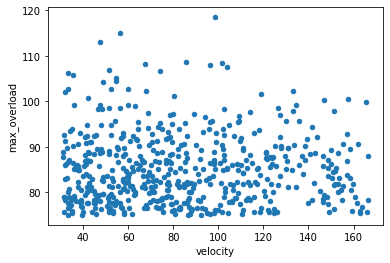

count    12605.000000
mean       109.492095
std        480.397695
min          0.000000
25%         16.554437
50%         47.078266
75%        109.891466
max      27576.740267
Name: velocity, dtype: float64


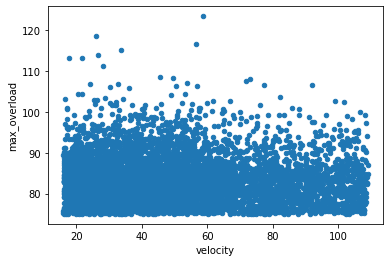

In [33]:
print(df1['velocity'].describe())
important_nodes_df.where((31 < important_nodes_df['velocity'])& (important_nodes_df['velocity'] < 167), None).plot.scatter('velocity', 'max_overload')
plt.show()

print(df1['velocity'].describe())
df1.where((16 < df1['velocity'])& (df1['velocity'] < 109), None).plot.scatter('velocity', 'max_overload')
plt.show()

In [34]:
important_nodes_df.corr()

,Sensor_id,Device_id,Latitude,Longitude,Speed,Channel1,Channel2,max_overload,5m_cluster,velocity
Sensor_id,1.000000,NaN,0.066279,0.014908,-0.032221,0.165218,-0.171897,0.013089,-0.019190,0.024498
Device_id,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Latitude,0.066279,NaN,1.000000,0.733097,-0.194001,0.025083,0.033131,0.216047,-0.145055,0.042974
Longitude,0.014908,NaN,0.733097,1.000000,-0.128986,-0.016927,0.043315,0.174694,-0.155218,-0.005593
Speed,-0.032221,NaN,-0.194001,-0.128986,1.000000,-0.094175,0.049016,-0.215624,0.205488,0.052906
Channel1,0.165218,NaN,0.025083,-0.016927,-0.094175,1.000000,-0.956857,0.121355,0.008948,0.020346
Channel2,-0.171897,NaN,0.033131,0.043315,0.049016,-0.956857,1.000000,0.108303,-0.124470,0.012723
max_overload,0.013089,NaN,0.216047,0.174694,-0.215624,0.121355,0.108303,1.000000,-0.591345,0.111763
5m_cluster,-0.019190,NaN,-0.145055,-0.155218,0.205488,0.008948,-0.124470,-0.591345,1.000000,-0.057837
velocity,0.024498,NaN,0.042974,-0.005593,0.052906,0.020346,0.012723,0.111763,-0.057837,1.000000


In [35]:
df1.corr()

,Sensor_id,Device_id,Latitude,Longitude,Speed,Channel1,Channel2,max_overload,5m_cluster,velocity
Sensor_id,1.000000,NaN,0.045795,0.002985,-0.009737,-0.013415,0.008011,0.001493,-0.036429,-0.036417
Device_id,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Latitude,0.045795,NaN,1.000000,0.731841,-0.162065,-0.014928,0.018798,0.042206,-0.244247,-0.074388
Longitude,0.002985,NaN,0.731841,1.000000,-0.128374,0.001726,0.015308,0.160407,-0.152551,-0.045568
Speed,-0.009737,NaN,-0.162065,-0.128374,1.000000,-0.015524,0.007806,-0.108481,0.333935,0.195037
Channel1,-0.013415,NaN,-0.014928,0.001726,-0.015524,1.000000,-0.961927,0.071683,0.011899,-0.000071
Channel2,0.008011,NaN,0.018798,0.015308,0.007806,-0.961927,1.000000,0.089077,-0.024321,-0.011550
max_overload,0.001493,NaN,0.042206,0.160407,-0.108481,0.071683,0.089077,1.000000,-0.137901,-0.061516
5m_cluster,-0.036429,NaN,-0.244247,-0.152551,0.333935,0.011899,-0.024321,-0.137901,1.000000,0.142887
velocity,-0.036417,NaN,-0.074388,-0.045568,0.195037,-0.000071,-0.011550,-0.061516,0.142887,1.000000


# Activites

## Summary statistics

In [36]:
important_df = df1[['Channel', 'Time', 'Channel1', 'Channel2', 'max_overload', 'Speed']]
important_df.describe()

,Channel1,Channel2,max_overload,Speed
count,12605.00000,12605.000000,12605.000000,12605.000000
mean,49.74467,42.385125,82.896242,3.211854
std,37.23737,37.422452,5.521888,11.367294
min,0.00000,0.000000,75.010800,0.000000
25%,7.88800,6.201600,78.553600,0.000000
50%,76.37760,20.617600,82.252800,0.000000
75%,82.90560,81.328000,85.897600,0.000000
max,118.48320,123.379200,123.379200,108.599221


## Feature distributions

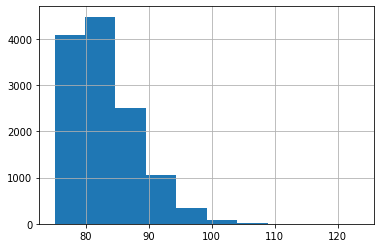

In [37]:
df1['max_overload'].hist()
plt.show()

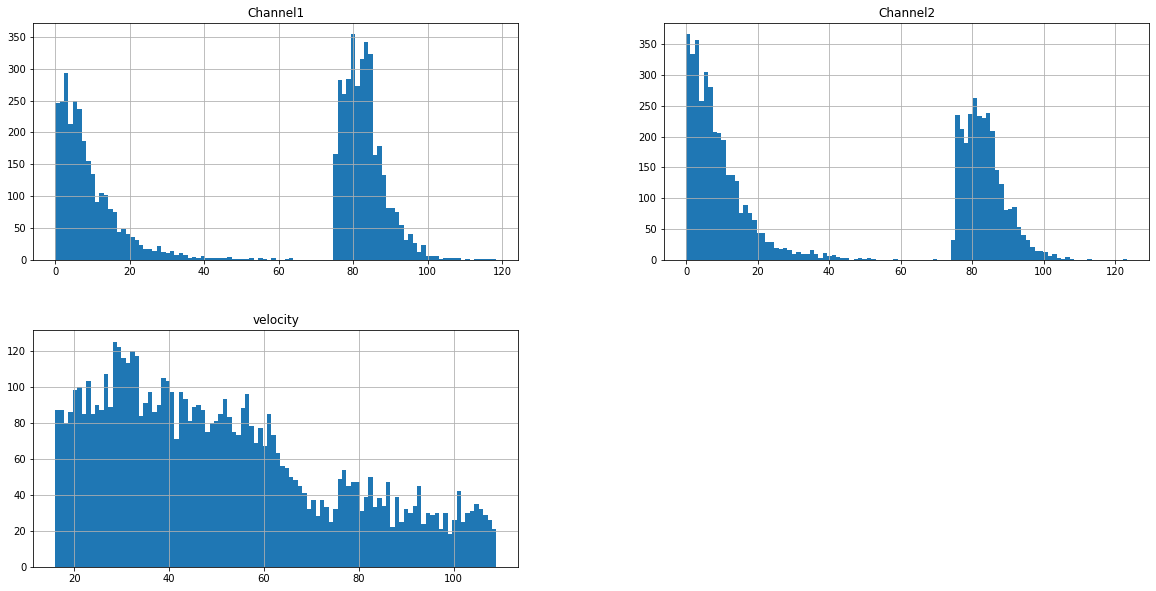

In [38]:
df1.where((16 < df1['velocity'])& (df1['velocity'] < 109), None).hist(['Channel1', 'Channel2', 'velocity'], figsize=(20, 10), bins=100)  # Choose the 25% - 75% velocity 
plt.show()

In [39]:
df1['velocity'].describe()

count    12605.000000
mean       109.492095
std        480.397695
min          0.000000
25%         16.554437
50%         47.078266
75%        109.891466
max      27576.740267
Name: velocity, dtype: float64

In [58]:
#add day of weak to our dataframe:

datetime = list(map(' '.join, df1[['Date', 'Time']].values.tolist()))
df1['Datetime'] = pd.to_datetime(pd.Series(datetime))
df1['day_of_weak'] = df1['Datetime'].dt.dayofweek
df1['day_of_weak'].value_counts()



4    3374
1    2621
2    2112
3    1571
5    1563
0     894
6     470
Name: day_of_weak, dtype: int64

## Feature correlations

### Plot a heatmap of correlations between features.

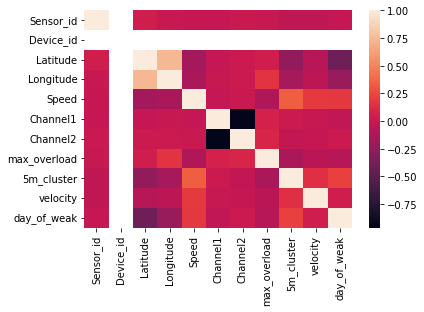

,Date,Time,max_overload,velocity,Latitude,Longitude
0,2021-03-04,04:11:13,76.1600,0.000000,59.374611,17.997831
1,2021-03-04,04:11:13,76.6020,24.748819,59.374611,17.997852
2,2021-03-04,04:11:14,84.7552,6.065887,59.374611,17.997877
3,2021-03-04,04:11:14,76.6020,62.114683,59.374610,17.997900
4,2021-03-04,04:11:14,79.1792,89.047221,59.374609,17.997925
...,...,...,...,...,...,...
12600,2021-11-08,23:09:41,76.4796,126.967055,59.376685,17.991453
12601,2021-11-08,23:09:41,78.0096,30.359506,59.376677,17.991481
12602,2021-11-08,23:09:41,76.6496,23.047543,59.376670,17.991506
12603,2021-11-08,23:09:43,75.7248,23.384502,59.376638,17.991621


In [53]:
import seaborn as sns
plt.figure()
correlation = df1.corr()
sns.heatmap(correlation)
plt.show()
df1
new_imp_df1 = df1[['Date','Time','max_overload','velocity','Latitude', 'Longitude']]
new_imp_df1


### Are any of the columns highly correlated with one another? Can you explain the correlation?

**Answer:** No!

### E.g., is there Is there a relationship between the speed and the overload? If so, what is it?

**Answer:** they have a revirse relationship